<a href="https://colab.research.google.com/github/PinChunPai/Cat_breeds_classification/blob/main/colab/Cat_breeds_basic_continue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cat breeds classification Continue**
In Cat_breeds_basic we have trained our fine_tune_model for 85 epochs. The accuracy approached 81.8% and the model is saved. Here we load it and keep training by smaller learning rate.

## **Steps**
Using the same setup and dataloader.


## **Setup**
Firstly, we import and install packages which will be used later. Start from fundamental commands for i/o, algebra and drawing.

In [1]:
## Fundamental packages for reading/writing files, algebra and plot
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 ### used for reading/writing images
import warnings
warnings.filterwarnings("ignore") ## ignore annoying warnings
from sklearn.model_selection import train_test_split ## For data preprocess

Then we import torch and relative packages used fo preprocess and load image datas

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

Now we install three packages:
* transformer: to use pre-trained vision transformer models
* evaluate: to provide various metrics to evaluate models
* gradio: to establish web demo

I am going to fix the version so I can use what I learn from class without worrying about version issues.

In [3]:
!pip install transformers==4.24.0
!pip install evaluate==0.3.0
!pip install gradio==3.12.0

## **1.Get data**
The dataset is stored in my google derive. So I define the relevant path for my derive. **This part should be modified on different enviroments.**

In this project I am going to use a cat breed dataset downloaded from [this Kaggle page](https://www.kaggle.com/datasets/knucharat/pop-cats). However the resourse can be tracked back to another [Petfinder](https://www.petfinder.com/developers/) \(available through [petpy](https://github.com/aschleg/petpy) \). The set I use in this project has been cleaned and it contains 20 common breeds, each containing 500 pictures. I further integrate the data and stored the reult in labels.csv.



In [4]:
path = '/content/drive/MyDrive/Project/Transformer_CV' ## It should be modified to the ACTUAL PATH storing dataset.

Let's take a look at labels.csv, which stores useful information.

In [5]:
all_data = pd.read_csv(os.path.join(path, 'labels.csv'))
all_data.head(5)

,id,breed
0,munchkin_478.jpg,Munchkin / 曼赤肯貓
1,americancurl_329.jpg,American Curl / 美國卷耳貓
2,birman_61.jpg,Birman / 伯曼貓
3,russianblue_199.jpg,Russian Blue / 俄羅斯藍貓
4,munchkin_429.jpg,Munchkin / 曼赤肯貓


It provides names of pictures and the corresponding labels. Let's convert 'id' to the actually path.

In [6]:
all_data['id'] = path + '/cats20/' + all_data['id']
all_data.head(5)

,id,breed
0,/content/drive/MyDrive/Project/Transformer_CV/...,Munchkin / 曼赤肯貓
1,/content/drive/MyDrive/Project/Transformer_CV/...,American Curl / 美國卷耳貓
2,/content/drive/MyDrive/Project/Transformer_CV/...,Birman / 伯曼貓
3,/content/drive/MyDrive/Project/Transformer_CV/...,Russian Blue / 俄羅斯藍貓
4,/content/drive/MyDrive/Project/Transformer_CV/...,Munchkin / 曼赤肯貓


## **2. EDA**
'id' of each row is exactly the name of each picture. Using them we can read pictures from corresponding folders.

In [7]:
breeds = all_data.breed.unique()
id2label = {i: label for i, label in enumerate(breeds)}
label2id = {v: k for k, v in id2label.items()}
all_data['labels'] = all_data['breed'].map(label2id)
y = all_data['breed'].to_frame()
train_val, test_data, y_train_val, y_test = train_test_split(all_data.drop("breed",axis =1), y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=0.11, random_state=42, shuffle=True, stratify=y_train_val)

In [8]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)


(8025, 2)
(992, 2)
(1002, 2)


## **Pre-Trained Model**
Before going to data preprocessing, we should take a look at the pre-trained model. Especially we want to look at format of its input and what it was trained for.



### **Install**
I will use vit provided by google, which is open sourced on [HuggingFace]()

In [9]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

model_id = 'google/vit-base-patch16-224'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForImageClassification.from_pretrained(model_id).to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

## **Preprocessing**
Since I am going to use google vit as pre-trained model, every input must fit the format of google vit. As we saw in the last section, google vit has a bulit-in preprocess to read different size of pictures. Despite the convenience, I will do preprocessing by myself because of the following reasons:
1. I want to train a model providing better results than google vit did in this specific task. Customed preprocessing allows us to try different strategies.
2. As a side project, I want to make sure that I am familiar with all necessary steps and understand how every part could impact the final result.

### **transform**

In [11]:
input_size =feature_extractor.size
mean = feature_extractor.image_mean
std = feature_extractor.image_std

In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

### **Dataset/Dataloader**
From [vit document](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) one can see that "pixel_values" and "labels" are two necessary inputs we should provide. Let's define dataset for following operations:
1. from input dataframe['id'] extract path and read image
2. transform images, the resultf will be in "pixel_values" column
3. from input dataframe['breed'] extract label and store it to gpu
4. return {"pixel_values":image, "labels",label}


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.data)  # Number of images
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'id']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.data.loc[idx, 'labels'], dtype=torch.long).to(device)  # Move label to GPU
        return {"pixel_values": image, "labels": label}

Now we can prepare dataloader for training, validation and testing data. Some hyperparameters such as batch size and prefetch factor should be tested later.

In [14]:
train_dataset = CustomImageDataset(train_data, transform=train_transform)
val_dataset = CustomImageDataset(val_data, transform=test_transform)
test_dataset = CustomImageDataset(test_data, transform=test_transform)

Let's construct another smaller dataloader for testing in the foloowing sections.

In [15]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## **Load model**


In [16]:
fine_tune_model = torch.load('/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')

## **Training**

We keep training by smaller learning rate.


### **Import packages**

In [17]:
from transformers import TrainingArguments, Trainer, DataCollator
from datasets import load_metric
import tensorboard


In [18]:
def collate_fn(batch):  ## reference: https://juejin.cn/post/7238148905095839804
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

### **Model training**

Epoch 1/60, Train Loss: 0.785759449005127, Val Loss: 0.6238047480583191, Accuracy: 0.8235887096774194
Epoch 2/60, Train Loss: 0.7472498416900635, Val Loss: 0.6194147206842899, Accuracy: 0.8266129032258065
Epoch 3/60, Train Loss: 0.5797434449195862, Val Loss: 0.6139232199639082, Accuracy: 0.8296370967741935
Epoch 4/60, Train Loss: 0.6543065905570984, Val Loss: 0.6097090318799019, Accuracy: 0.8245967741935484
Epoch 5/60, Train Loss: 1.0709131956100464, Val Loss: 0.6065278071910143, Accuracy: 0.8286290322580645
Epoch 6/60, Train Loss: 0.538526713848114, Val Loss: 0.6022908017039299, Accuracy: 0.8286290322580645
Epoch 7/60, Train Loss: 0.8937051296234131, Val Loss: 0.5975089650601149, Accuracy: 0.8316532258064516
Epoch 8/60, Train Loss: 0.75498366355896, Val Loss: 0.5932747330516577, Accuracy: 0.8336693548387096
Epoch 9/60, Train Loss: 0.6960527300834656, Val Loss: 0.5899194143712521, Accuracy: 0.8336693548387096
Epoch 10/60, Train Loss: 0.795235812664032, Val Loss: 0.5860333200544119, Acc

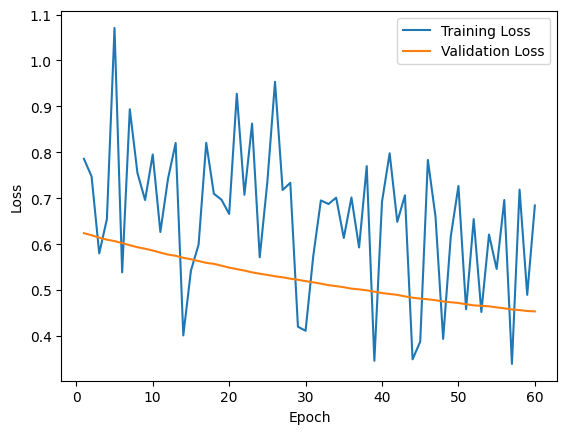

0.45345798693597317


In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.0005)
# Training and Validation loop
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Set to positive infinity initially
best_weights_path = 'best_model_weights.pth'

num_epochs = 60
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

Epoch 1/30, Train Loss: 0.4175107181072235, Val Loss: 0.44567301869392395, Accuracy: 0.8719758064516129
Epoch 2/30, Train Loss: 0.7140920162200928, Val Loss: 0.4339196477085352, Accuracy: 0.8709677419354839
Epoch 3/30, Train Loss: 0.222598135471344, Val Loss: 0.42904409393668175, Accuracy: 0.8659274193548387
Epoch 4/30, Train Loss: 0.7280155420303345, Val Loss: 0.42226330004632473, Accuracy: 0.8689516129032258
Epoch 5/30, Train Loss: 0.5819069147109985, Val Loss: 0.4127493090927601, Accuracy: 0.8669354838709677
Epoch 6/30, Train Loss: 0.39808768033981323, Val Loss: 0.40973478741943836, Accuracy: 0.8770161290322581
Epoch 7/30, Train Loss: 0.4114876985549927, Val Loss: 0.3983179535716772, Accuracy: 0.8780241935483871
Epoch 8/30, Train Loss: 0.3971545398235321, Val Loss: 0.3943073274567723, Accuracy: 0.8790322580645161
Epoch 9/30, Train Loss: 0.5944018363952637, Val Loss: 0.38826207164675, Accuracy: 0.8860887096774194
Epoch 10/30, Train Loss: 0.38549086451530457, Val Loss: 0.3859094781801

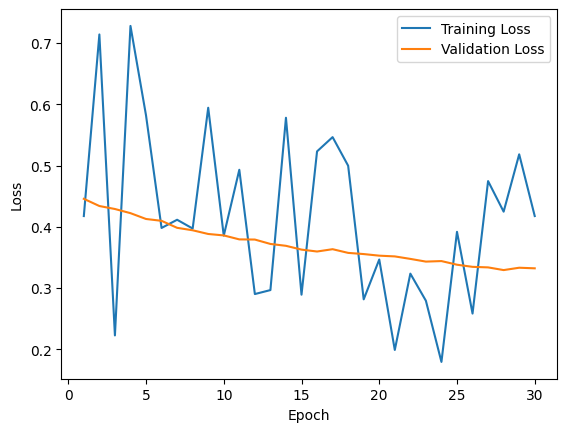

0.32929600216448307


In [20]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.0025)
# Training and Validation loop
train_losses = []
val_losses = []
num_epochs = 30
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

Epoch 1/10, Train Loss: 0.16496622562408447, Val Loss: 0.32514663413167, Accuracy: 0.8991935483870968
Epoch 2/10, Train Loss: 0.6158511638641357, Val Loss: 0.3259831489995122, Accuracy: 0.8911290322580645
Epoch 3/10, Train Loss: 0.20047615468502045, Val Loss: 0.3202114850282669, Accuracy: 0.8901209677419355
Epoch 4/10, Train Loss: 0.3198099136352539, Val Loss: 0.320441716350615, Accuracy: 0.8951612903225806
Epoch 5/10, Train Loss: 0.36230140924453735, Val Loss: 0.3224339568987489, Accuracy: 0.8941532258064516
Epoch 6/10, Train Loss: 0.7399352192878723, Val Loss: 0.31561674550175667, Accuracy: 0.9002016129032258
Epoch 7/10, Train Loss: 0.5323154926300049, Val Loss: 0.3153929403051734, Accuracy: 0.8911290322580645
Epoch 8/10, Train Loss: 0.2309568226337433, Val Loss: 0.3105395808815956, Accuracy: 0.9012096774193549
Epoch 9/10, Train Loss: 0.2505825459957123, Val Loss: 0.309506974183023, Accuracy: 0.8981854838709677
Epoch 10/10, Train Loss: 0.344109445810318, Val Loss: 0.30926533322781324

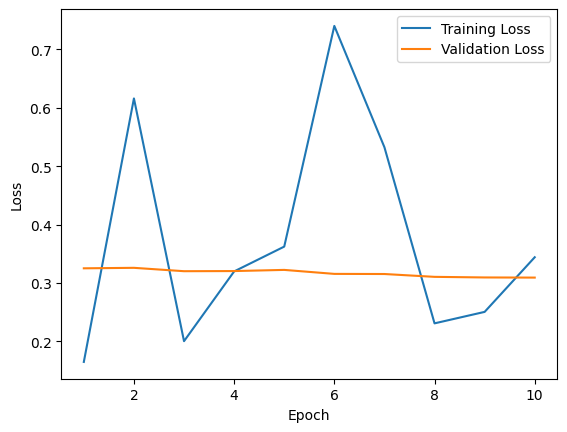

0.30926533322781324


In [21]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.003)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

Epoch 1/10, Train Loss: 0.31364601850509644, Val Loss: 0.30997838359326124, Accuracy: 0.9002016129032258
Epoch 2/10, Train Loss: 0.47708263993263245, Val Loss: 0.31168030574917793, Accuracy: 0.9012096774193549
Epoch 3/10, Train Loss: 0.5226779580116272, Val Loss: 0.29763058479875326, Accuracy: 0.9032258064516129
Epoch 4/10, Train Loss: 0.26944682002067566, Val Loss: 0.30745990481227636, Accuracy: 0.8961693548387096
Epoch 5/10, Train Loss: 0.25157320499420166, Val Loss: 0.30463495291769505, Accuracy: 0.8991935483870968
Epoch 6/10, Train Loss: 0.07871608436107635, Val Loss: 0.30220009479671717, Accuracy: 0.8931451612903226
Epoch 7/10, Train Loss: 0.49413570761680603, Val Loss: 0.30154728796333075, Accuracy: 0.8951612903225806
Epoch 8/10, Train Loss: 0.20451989769935608, Val Loss: 0.2947653168812394, Accuracy: 0.9042338709677419
Epoch 9/10, Train Loss: 0.4596984088420868, Val Loss: 0.2934424029663205, Accuracy: 0.9012096774193549
Epoch 10/10, Train Loss: 0.0928213894367218, Val Loss: 0.30

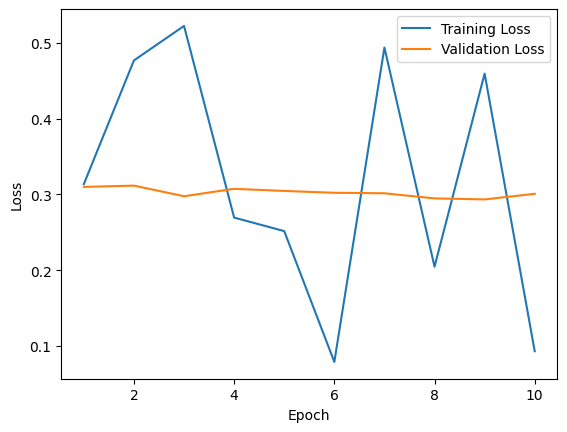

0.2934424029663205


In [22]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.005)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

After 175 epochs, validation loss stops to decrease and we get ~90% accuracy. It is possible that the model is trapped at a saddle point or local minimum. We can do some experiment to try to escape. Some idea:
1. Adjust learning rate and batch size.
2. Try other optimizers
3. Try other loss functions.

Firstly I will try the approach 1. If it doesn'y work then nextly we try approach 2.



In [24]:
small_train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
small_val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Epoch 1/15, Train Loss: 0.8930004835128784, Val Loss: 0.29731085175468075, Accuracy: 0.8991935483870968
Epoch 2/15, Train Loss: 0.34011298418045044, Val Loss: 0.2971850780229415, Accuracy: 0.9002016129032258
Epoch 3/15, Train Loss: 0.10416951775550842, Val Loss: 0.29572826071131614, Accuracy: 0.8991935483870968
Epoch 4/15, Train Loss: 0.21290279924869537, Val Loss: 0.2957625182405595, Accuracy: 0.9022177419354839
Epoch 5/15, Train Loss: 0.2062247395515442, Val Loss: 0.2967843028806871, Accuracy: 0.8971774193548387
Epoch 6/15, Train Loss: 0.22333377599716187, Val Loss: 0.29727638945464163, Accuracy: 0.8961693548387096
Epoch 7/15, Train Loss: 0.5037443041801453, Val Loss: 0.2953373304297847, Accuracy: 0.8971774193548387
Epoch 8/15, Train Loss: 0.28393203020095825, Val Loss: 0.29462377654929317, Accuracy: 0.9012096774193549
Epoch 9/15, Train Loss: 0.35468587279319763, Val Loss: 0.2958991969785383, Accuracy: 0.8961693548387096
Epoch 10/15, Train Loss: 0.19929607212543488, Val Loss: 0.29334

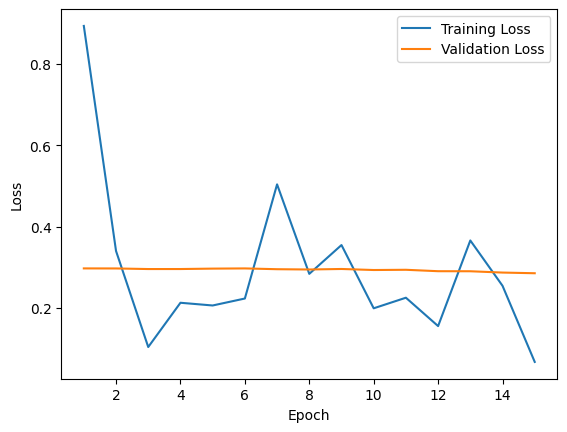

0.2854341095493686


In [25]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.001)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in small_train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in small_val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(small_val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

It seems to work so let's do another 15 epcoh

Epoch 1/15, Train Loss: 0.5573562979698181, Val Loss: 0.28664041839299664, Accuracy: 0.9022177419354839
Epoch 2/15, Train Loss: 0.08787225931882858, Val Loss: 0.2850506180717099, Accuracy: 0.9032258064516129
Epoch 3/15, Train Loss: 0.12119026482105255, Val Loss: 0.2841566068030173, Accuracy: 0.8991935483870968
Epoch 4/15, Train Loss: 0.16122132539749146, Val Loss: 0.28328850168374275, Accuracy: 0.9032258064516129
Epoch 5/15, Train Loss: 0.20680999755859375, Val Loss: 0.28436111803016356, Accuracy: 0.9032258064516129
Epoch 6/15, Train Loss: 0.3324774503707886, Val Loss: 0.28604913022248973, Accuracy: 0.907258064516129
Epoch 7/15, Train Loss: 0.17629383504390717, Val Loss: 0.2883139531458578, Accuracy: 0.907258064516129
Epoch 8/15, Train Loss: 0.031010787934064865, Val Loss: 0.28589231977539675, Accuracy: 0.9082661290322581
Epoch 9/15, Train Loss: 0.13148076832294464, Val Loss: 0.28415710839533037, Accuracy: 0.9112903225806451
Epoch 10/15, Train Loss: 0.06505829840898514, Val Loss: 0.283

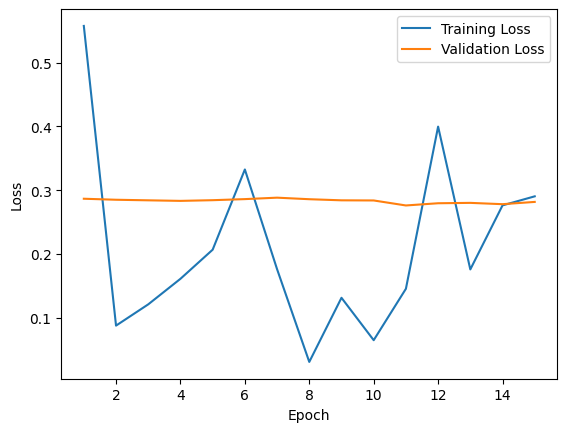

0.2761051582713281


In [26]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.002)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in small_train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in small_val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(small_val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

Training loss is still oscillating. Let's setup smaller learning rate and restore the larger batch size.

Epoch 1/15, Train Loss: 0.18800164759159088, Val Loss: 0.27738715521991253, Accuracy: 0.90625
Epoch 2/15, Train Loss: 0.2205759435892105, Val Loss: 0.2757266638800502, Accuracy: 0.905241935483871
Epoch 3/15, Train Loss: 0.21600745618343353, Val Loss: 0.2747092042118311, Accuracy: 0.907258064516129
Epoch 4/15, Train Loss: 0.40444305539131165, Val Loss: 0.27404805086553097, Accuracy: 0.9092741935483871
Epoch 5/15, Train Loss: 0.08718804270029068, Val Loss: 0.2735297936014831, Accuracy: 0.9102822580645161
Epoch 6/15, Train Loss: 0.15672023594379425, Val Loss: 0.27319951448589563, Accuracy: 0.9082661290322581
Epoch 7/15, Train Loss: 0.14995723962783813, Val Loss: 0.2728319363668561, Accuracy: 0.907258064516129
Epoch 8/15, Train Loss: 0.37238118052482605, Val Loss: 0.27312647830694914, Accuracy: 0.9082661290322581
Epoch 9/15, Train Loss: 0.1322697103023529, Val Loss: 0.27305192220956087, Accuracy: 0.90625
Epoch 10/15, Train Loss: 0.5507441163063049, Val Loss: 0.27298807445913553, Accuracy: 

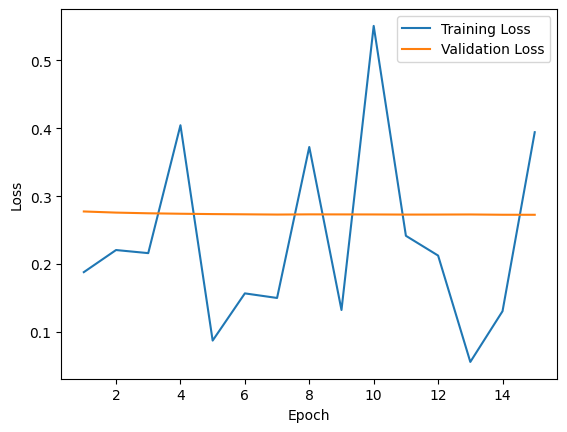

0.2725079976953566


In [27]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.0001)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

In [29]:
fine_tune_model = torch.load('/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')

Epoch 1/15, Train Loss: 0.2187327742576599, Val Loss: 0.27250712364912033, Accuracy: 0.907258064516129
Epoch 2/15, Train Loss: 0.326185405254364, Val Loss: 0.2727542445063591, Accuracy: 0.9082661290322581
Epoch 3/15, Train Loss: 0.13790111243724823, Val Loss: 0.27279913565143943, Accuracy: 0.9082661290322581
Epoch 4/15, Train Loss: 0.22105489671230316, Val Loss: 0.27265632525086403, Accuracy: 0.90625
Epoch 5/15, Train Loss: 0.25133687257766724, Val Loss: 0.27272122213616967, Accuracy: 0.907258064516129
Epoch 6/15, Train Loss: 0.4793636202812195, Val Loss: 0.27294697100296617, Accuracy: 0.907258064516129
Epoch 7/15, Train Loss: 0.18891316652297974, Val Loss: 0.2729119095019996, Accuracy: 0.907258064516129
Epoch 8/15, Train Loss: 0.0639515221118927, Val Loss: 0.2728775478899479, Accuracy: 0.90625
Epoch 9/15, Train Loss: 0.12392421811819077, Val Loss: 0.2729293159209192, Accuracy: 0.9092741935483871
Epoch 10/15, Train Loss: 0.34111666679382324, Val Loss: 0.27276722295209765, Accuracy: 0.9

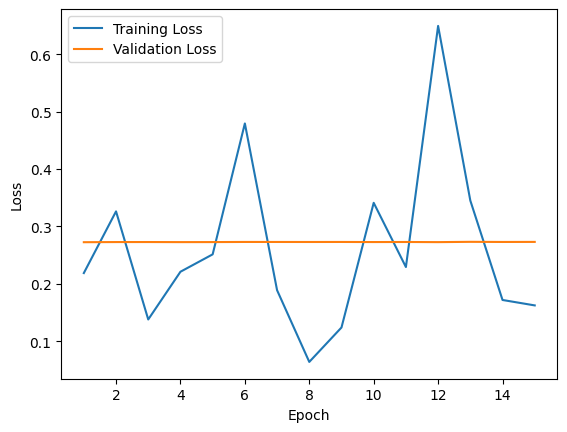

0.27250712364912033


In [30]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.0001)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

We can see that validation loss already converges. It means that we may not be able to improve model by push it through more epoch. However, I want to utlize all data to train the final model--this gives us the best expectation of model performance. To do so, I will train the model on the whole train_val dataset and use test dataset to evaluate it. If this process doesn't ruin everything then we use all dataset to train the final model by the same way.  

In [31]:
train_val_dataset = CustomImageDataset(train_val, transform=train_transform)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

Epoch 1/15, Train_Val Loss: 0.2954730689525604, Test Loss: 0.26134618930518627, Accuracy: 0.9251497005988024
Epoch 2/15, Train_Val Loss: 0.39702633023262024, Test Loss: 0.260956599842757, Accuracy: 0.9261477045908184
Epoch 3/15, Train_Val Loss: 0.3092125654220581, Test Loss: 0.260960410349071, Accuracy: 0.9261477045908184
Epoch 4/15, Train_Val Loss: 0.21267662942409515, Test Loss: 0.2605104981921613, Accuracy: 0.9261477045908184
Epoch 5/15, Train_Val Loss: 0.2748646140098572, Test Loss: 0.26040983851999044, Accuracy: 0.9251497005988024
Epoch 6/15, Train_Val Loss: 0.39427244663238525, Test Loss: 0.2604459337890148, Accuracy: 0.9251497005988024
Epoch 7/15, Train_Val Loss: 0.12569253146648407, Test Loss: 0.26067083701491356, Accuracy: 0.9251497005988024
Epoch 8/15, Train_Val Loss: 0.426601380109787, Test Loss: 0.26058247312903404, Accuracy: 0.9261477045908184
Epoch 9/15, Train_Val Loss: 0.3479883074760437, Test Loss: 0.2605746230110526, Accuracy: 0.9251497005988024
Epoch 10/15, Train_Val 

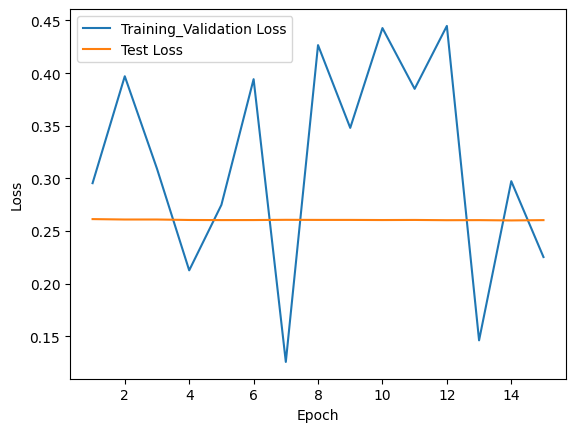

0.26008552173152566


In [32]:
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.0001)
# Training and Validation loop
train_losses = []
val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_val_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in test_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(test_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    if average_val_loss < best_val_loss:
      best_val_loss = average_val_loss

            # Save the current best model weights
      torch.save(fine_tune_model, '/content/drive/MyDrive/Project/Transformer_CV/models/model.pt')


    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train_Val Loss: {loss.item()}, Test Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training_Validation Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(best_val_loss)

Surprisingly, both loss an accuracy improve largely on test dataset. There are three possibilities:
1. The model was trapped in a region with zero gradient, and adding validation set into training process help it to escape. It would be the best situation because this model does learn more thing and improve its ability.

2. It could be the case that test dataset is more like training dataset that validation dataset is. In this case the higher performance just reflect the overfitting on training dataset.

3. Part of the change may due to the raio of train_val and test is now 9:1, larger than the original train-val radio, 8:1.

Nevertheless, it is a good news that we see a better performance. Even in the worst case, adding new data into training process doesn't ruin the model. Therefore we can use the similar way to utilize the whole dataset to train the final model and expect it won't be worse than the present one. Notice that in this final training we won't have any other data to validate so we just train it and save the final result as "cat20_breeds.pt".